## Imports

In [141]:
import sqlite3
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

## Initialisations

In [142]:
## Initialise paths
db_path = os.path.join('../', 'challenge.db')

## Connect to the db

In [143]:
conn  = sqlite3.connect(db_path)

## Fetch data from db

In [144]:
# Query the db
tables_list = ['conversions', 'session_sources', 'conversions_backend', 'api_adwords_costs', 'attribution_customer_journey']
dataframes = {}
for table in tables_list:
    query = f"SELECT * FROM {table}"
    df_name = f"{table}_df"
    dataframes[df_name] = pd.read_sql_query(query, conn)

# Close db connnection    
conn.close()

In [145]:
conversions_df = dataframes['conversions_df']
session_sources_df = dataframes['session_sources_df']
conversions_backend_df = dataframes['conversions_backend_df']
api_adwords_costs_df = dataframes['api_adwords_costs_df']
attribution_customer_journey_df = dataframes['attribution_customer_journey_df']

Now I have all the tables in dataframes ready to be explored.

## Explore dataframes

### Conversions

* conv_id: unique identifier of this conversion
* user_id: user identifier
* conv_date: date when the conversion happened
* market: regional market that this conversion belongs to
* revenue: conversion amount (i.e. how much revenue the company earned through this conversion, you can assume its in Euro)

In [146]:
# Read the dataframe
conversions_df.head(3)

,conv_id,user_id,conv_date,market,revenue
0,conv_id_16788,user_id_569581,2021-07-15,NL,219.73
1,conv_id_9916,user_id_62541,2021-07-15,DE,104.21
2,conv_id_8443,user_id_494266,2021-07-15,NL,55.69


It looks like the conv_id contains conversion ids with prefix `conv_id_`, and user ids with `user_id_`. The date is in the format `yyyy-mm-dd` and market contains country codes such as NL, DE for Netherlands and Germany. The revenue is in Euros.

In [147]:
conversions_df.describe(include='all').fillna('')

,conv_id,user_id,conv_date,market,revenue
count,16954,16954,16954,16954,16954.0
unique,16938,16373,17,28,
top,conv_id_291,user_id_210830,2021-07-30,GB,
freq,2,179,2294,5766,
mean,,,,,50.082734
std,,,,,55.872318
min,,,,,0.0
25%,,,,,25.13
50%,,,,,39.67
75%,,,,,65.34


In [148]:
for column in conversions_df.columns:
    print(column, type(conversions_df[column].loc[0]))

conv_id <class 'str'>
user_id <class 'str'>
conv_date <class 'str'>
market <class 'str'>
revenue <class 'numpy.float64'>


In [149]:
conversions_df.isnull().sum()

conv_id      0
user_id      0
conv_date    0
market       0
revenue      0
dtype: int64

In [150]:
# Check for duplicates in conv_id column
duplicates = conversions_df[conversions_df.duplicated(subset=['conv_id'], keep=False)]
duplicates.sort_values(by=['conv_id'])

,conv_id,user_id,conv_date,market,revenue
13570,conv_id_10826,user_id_172209,2021-07-30,NL,44.96
16949,conv_id_10826,user_id_197806,2021-07-30,NL,44.96
13696,conv_id_1128,user_id_1075383,2021-07-30,FR,68.33
16950,conv_id_1128,user_id_592828,2021-07-30,FR,68.33
12343,conv_id_11991,user_id_8521,2021-07-28,GB,70.72
16948,conv_id_11991,user_id_1111998,2021-07-28,GB,70.72
14465,conv_id_12394,user_id_102818,2021-07-30,DE,45.71
16951,conv_id_12394,user_id_381420,2021-07-30,DE,45.71
16947,conv_id_12408,user_id_405560,2021-07-27,FR,80.04
10843,conv_id_12408,user_id_57098,2021-07-27,FR,80.04


From the above, we can see that no all conv_ids are unique. There are some which are duplicates - conv_ids with more than 1 user_ids but same data in other columns. This is a possible quality issue.

Moreover, all the columns are of string datatype. It can be noted that even the date is in string format. May be we need to use `datetime` to use the date values effectively. Also, note that there are 28 markets. Also, there are no null values in the data.

Now let's look into each column.

In [151]:
# conv_id
conversions_df['conv_id'].sample(3)

16098    conv_id_12755
9019        conv_id_80
4942     conv_id_12016
Name: conv_id, dtype: object

In [152]:
# user_id
conversions_df['user_id'].sample(3)

3600      user_id_522647
11182     user_id_953118
3760     user_id_1102280
Name: user_id, dtype: object

In [153]:
# conv_date
print(f"The min date is {conversions_df['conv_date'].min()}")
print(f"The max date is {conversions_df['conv_date'].max()}")
print(f"The count of unique dates are {conversions_df['conv_date'].nunique()}")
print(f"The unique dates are given below \n {conversions_df['conv_date'].unique()}")
print(f"The datatype of date value is {type(conversions_df['conv_date'].loc[0])}")

The min date is 2021-07-15
The max date is 2021-07-31
The count of unique dates are 17
The unique dates are given below 
 ['2021-07-15' '2021-07-16' '2021-07-17' '2021-07-18' '2021-07-19'
 '2021-07-20' '2021-07-21' '2021-07-22' '2021-07-23' '2021-07-24'
 '2021-07-25' '2021-07-26' '2021-07-27' '2021-07-28' '2021-07-29'
 '2021-07-30' '2021-07-31']
The datatype of date value is <class 'str'>


In [154]:
# market
conversions_df['market'].sample(3)

15265    GB
16142    NL
12229    GB
Name: market, dtype: object

In [155]:
print(f"The count of unique markets are {conversions_df['market'].nunique()}")
print(f"The unique market are given below \n {conversions_df['market'].unique()}")

The count of unique markets are 28
The unique market are given below 
 ['NL' 'DE' 'AT' 'FR' 'BE' 'DK' 'IT' 'ES' 'CY' 'IE' 'LV' 'GB' 'SE' 'HU'
 'LU' 'PT' 'FI' 'SI' 'BG' 'SK' 'PL' 'GR' 'EE' 'LT' 'CZ' 'HR' 'MT' 'EU']


In [156]:
# revenue
conversions_df['revenue'].sample(3)

9497     8.40
9380    68.09
8468    30.87
Name: revenue, dtype: float64

In [157]:
print(f"The min revenue is {conversions_df['revenue'].min()}")
print(f"The max revenue is {conversions_df['revenue'].max()}")

The min revenue is 0.0
The max revenue is 1839.2


At the first glance the min revenue is 0.0. Let's investigate this.

In [158]:
print(f"Number of conversions which show revenue as 0.0 are {len(conversions_df[conversions_df['revenue']==0.0])}")
conversions_df[conversions_df['revenue']==0.0].head(3)

Number of conversions which show revenue as 0.0 are 197


,conv_id,user_id,conv_date,market,revenue
7,conv_id_11478,user_id_758246,2021-07-15,DE,0.0
10,conv_id_87,user_id_376090,2021-07-15,FR,0.0
151,conv_id_15098,user_id_47785,2021-07-15,NL,0.0


This looks like a data quality issue. But there can be other reasons for this such as:
1. A user used a 100% discount code while purchasing the item.
2. Problem while performing the purchase, may be the conversion was recorded but due to issue with payment the revenue was not processed.

### Conversions Backend

* conv_id: unique identifier of this conversion
* user_id: user identifier
* conv_date: date when the conversion happened
* market: regional market that this conversion belongs to
* revenue: conversion amount


In [159]:
conversions_backend_df.head(3)

,conv_id,user_id,conv_date,market,revenue
0,conv_id_16788,user_id_569581,2021-07-15,NL,219.73
1,conv_id_9916,user_id_62541,2021-07-15,DE,104.21
2,conv_id_8443,user_id_494266,2021-07-15,NL,55.69


The conversions backend represent the true data and should contain exact same data as in conversions dataframe. We can check for inconsistencies, if any.

In [160]:
print(f"count of records in conversions daraframe is {conversions_df.shape[0]}")
print(f"count of records in conversions backend daraframe is {conversions_backend_df.shape[0]}")
print(f"There are {conversions_backend_df.shape[0]-conversions_df.shape[0]} more records in conversions backend than conversions")

count of records in conversions daraframe is 16954
count of records in conversions backend daraframe is 17283
There are 329 more records in conversions backend than conversions


### Session Sources

* session_id: unique identifier of this session
* user_id: user identifier
* event_date: date when the session happened
* event_time: time when the session happened
* channel_name: traffic channel that started this session (e.g. 'Email')
* campaign_name: advertising campaign name that started this session (e.g. 'adwords_campaign_123')
* campaign_id: campaign identifier that started this session (not all sessions have a campaign_id)
* market: regional market that this session belongs to (e.g. 'DE' for Germany)
* cpc: cost-per-click of this (this is how much was paid for this session, you can assume its in Euro)


In [161]:
session_sources_df.head(3)

,session_id,user_id,event_date,event_time,channel_name,campaign_name,campaign_id,market,cpc
0,session_id_660241,user_id_814496,2021-07-03,05:30:20,Affiliate,campaign_name_716,notset,NL,0.018
1,session_id_9812,user_id_752875,2021-07-19,16:00:40,Affiliate,campaign_name_108,notset,FR,0.000
2,session_id_780253,user_id_156905,2021-07-31,07:50:23,Affiliate,campaign_name_741,notset,DE,0.022


In [162]:
session_sources_df.describe(include='all').fillna('')

,session_id,user_id,event_date,event_time,channel_name,campaign_name,campaign_id,market,cpc
count,1616702,1616702,1616702,1616702,1616702,1616702,1616702,1616702,1616702.0
unique,1616702,1153719,31,86248,28,1189,164,6,
top,session_id_660241,user_id_970731,2021-07-04,00:00:00,SEO,campaign_name_741,notset,DE,
freq,1,208,73342,308,310277,1095102,1088000,464209,
mean,,,,,,,,,0.420779
std,,,,,,,,,1.057887
min,,,,,,,,,0.0
25%,,,,,,,,,0.0
50%,,,,,,,,,0.0
75%,,,,,,,,,0.688


Let's check some of the columns

In [163]:
# Channel name
session_sources_df['channel_name'].sample(3)

1473142             Social - Paid
1176255    Shopping - Non-branded
1546602               Social Paid
Name: channel_name, dtype: object

In [164]:
print(f"There are {len(session_sources_df['channel_name'].unique())} unique channels and they are below \n {session_sources_df['channel_name'].unique()}")

There are 28 unique channels and they are below 
 ['Affiliate' 'Affiliates' 'Content Marketing' 'Direct' 'Direct Traffic'
 'Display' 'Display Remarketing' 'Email' 'Google Remarketing'
 'Influencers' 'Referral' 'SEA (no tagging)' 'SEA - Brand' 'SEA - Branded'
 'SEA - Non-Brand' 'SEA - Non-branded' 'SEO' 'Shopping - Brand'
 'Shopping - Branded' 'Shopping - Non Brand' 'Shopping - Non-branded'
 'Social - Organic' 'Social - Paid' 'Social Organic' 'Social Paid'
 'Social Remarketing' 'Video Marketing' 'YouTube Video Ads']


In [165]:
# Campaign id
session_sources_df['campaign_id'].sample(3)

494762              notset
1166516    campaign_id_149
1560387             notset
Name: campaign_id, dtype: object

In [166]:
print(f"There are {len(session_sources_df['campaign_id'].unique())} unique campaign ids")

There are 164 unique campaign ids


We can see that one of the campaign ids are `notset`

In [167]:
print(f"There are {session_sources_df[session_sources_df['campaign_id']=='notset'].shape[0]} out of {session_sources_df['campaign_id'].shape[0]} sessions with campaign id notset")

There are 1088000 out of 1616702 sessions with campaign id notset


In [168]:
# market
session_sources_df['market'].sample(3)


122940     GB
1586267    FR
871515     FR
Name: market, dtype: object

In [169]:
session_sources_df['market'].unique()

array(['NL', 'FR', 'DE', 'GB', 'DK', 'EU'], dtype=object)

In [170]:
# cpc
session_sources_df['cpc'].sample(3)

print(f"The min cpc is {session_sources_df['cpc'].min()}")
print(f"The max cpc is {session_sources_df['cpc'].max()}")

The min cpc is 0.0
The max cpc is 441.25


We can see that cpc is 0.0 in some cases. This could be traffic which did not require adwords and the customer visited the website on her on accord. The worst case scenario is that the data is missing for these sessions due to technical/human failure and cpc is set to 0.0.

### Attribution Customer Journey

* conv_id: conversion identifier
* session_id: session identifier that belonged in the customer journey of the given conv_id
* ihc: 'value' of the given session in the given customer journey (1 = 100%)

In [171]:
attribution_customer_journey_df.sample(3)

,conv_id,session_id,ihc
13649,conv_id_6203,session_id_1501592,0.000000
19546,conv_id_11526,session_id_56260,0.022205
19411,conv_id_6120,session_id_502863,0.442793


In [172]:
# Get unique conv ids from conversions and attribution customer journey
conversion_ids = set(conversions_df['conv_id'])
attribution_conversion_ids = set(attribution_customer_journey_df['conv_id'])

# Find conv_ids in conversions that are not in attribution_customer_journey
missing_conv_ids = conversion_ids - attribution_conversion_ids

# Check if there are any missing
if missing_conv_ids:
    print(f"Number of Conversions without corresponding sessions in attribution_customer_journey are {len(missing_conv_ids)}")
else:
    print("All conversions have corresponding sessions in attribution_customer_journey.")

Number of Conversions without corresponding sessions in attribution_customer_journey are 10076


This discrepancy can indicate potential data quality issue. This could be a result of data incompleteness or issues with data being recorded. Ideally, conversions in conversions table should be present in attribution customer journey table as well.

In [173]:
# Get unique session ids from attribution customer journey and session_sources
attribution_session_ids = set(attribution_customer_journey_df['session_id'])
session_ids = set(session_sources_df['session_id'])

# Find session ids in attribution customer journey that are not in session sources
missing_session_ids = attribution_session_ids - session_ids

# Check if there are any missing convs
if missing_session_ids:
    print(f"Number of sessions in attribution_customer_journey not found in session_sources {len(missing_session_ids)}")
else:
    print("All sessions in attribution_customer_journey are present in session_sources.")

All sessions in attribution_customer_journey are present in session_sources.


In [174]:
# ihc
attribution_customer_journey_df['ihc'].sample(5)

14981    0.000000
19507    1.000000
10305    0.000000
20446    0.167664
19719    1.000000
Name: ihc, dtype: float64

In [175]:
grouped_attr = attribution_customer_journey_df.groupby(['conv_id']).sum(['ihc'])
grouped_attr[grouped_attr['ihc']<1.0].sample(5)

,ihc
conv_id,
conv_id_13941,1.0
conv_id_5158,1.0
conv_id_14602,1.0
conv_id_17010,1.0
conv_id_3115,1.0


We can see that there are some conversions with less that 1 total ihc.

### API Adwords Costs

* event_date: date when the AdWords campaign was running
* campaign_id: campaign identifier
* cost: amount that was spent on running this campaign on this day (assume its in Euro)
* clicks: number of times a user clicked on this ad on the given day

In [176]:
api_adwords_costs_df.sample(3)

,event_date,campaign_id,cost,clicks
1259,2021-07-15,campaign_id_155,54.914,30
1994,2021-07-16,campaign_id_63,11.400,28
1286,2021-07-24,campaign_id_82,51.014,79


In [177]:
# Most/Least clicks
print(f"Most number of clicks - {api_adwords_costs_df['clicks'].max()}")
print(f"Least number of clicks - {api_adwords_costs_df['clicks'].min()}")

Most number of clicks - 7467
Least number of clicks - 0


We can see that the least number of clicks is 0. It is important to check these records with zero clicks.

In [178]:
# Check cost for 0 clicks for sanity check
zero_click = api_adwords_costs_df[(api_adwords_costs_df['clicks']==0) & (api_adwords_costs_df['cost'] > 0.0)]
zero_click

,event_date,campaign_id,cost,clicks
2302,2021-07-02,campaign_id_156,7.031,0
2309,2021-07-17,campaign_id_94,6.975,0
2410,2021-07-11,campaign_id_94,5.976,0
2595,2021-07-04,campaign_id_94,3.908,0
2603,2021-07-05,campaign_id_156,3.816,0
2640,2021-07-10,campaign_id_94,3.458,0
2795,2021-07-01,campaign_id_7,1.844,0
2862,2021-07-20,campaign_id_94,1.368,0
2889,2021-07-09,campaign_id_7,1.108,0
2894,2021-07-20,campaign_id_7,1.067,0


It highly suspicious that there are costs involved for some campaigns but no recorded clicks. Now let's check if these campaign ids are present in session sources table or not.

In [179]:
related_sessions = session_sources_df[session_sources_df['campaign_id'].isin(zero_click['campaign_id'].unique())]

if not related_sessions.empty:
    print("There are related sessions from session_sources_df")
else:
    print("No related sessions found in session_sources_df for campaigns with non-zero costs and 0 clicks.")

There are related sessions from session_sources_df


   event_date      campaign_id   cost  clicks  session_count  total_cpc
0  2021-07-02  campaign_id_156  7.031       0             30     90.823
1  2021-07-17   campaign_id_94  6.975       0             21     40.740
2  2021-07-11   campaign_id_94  5.976       0             21     40.740
3  2021-07-04   campaign_id_94  3.908       0             21     40.740
4  2021-07-05  campaign_id_156  3.816       0             30     90.823
5  2021-07-10   campaign_id_94  3.458       0             21     40.740
6  2021-07-01    campaign_id_7  1.844       0            135    338.712
7  2021-07-20   campaign_id_94  1.368       0             21     40.740
8  2021-07-09    campaign_id_7  1.108       0            135    338.712
9  2021-07-20    campaign_id_7  1.067       0            135    338.712


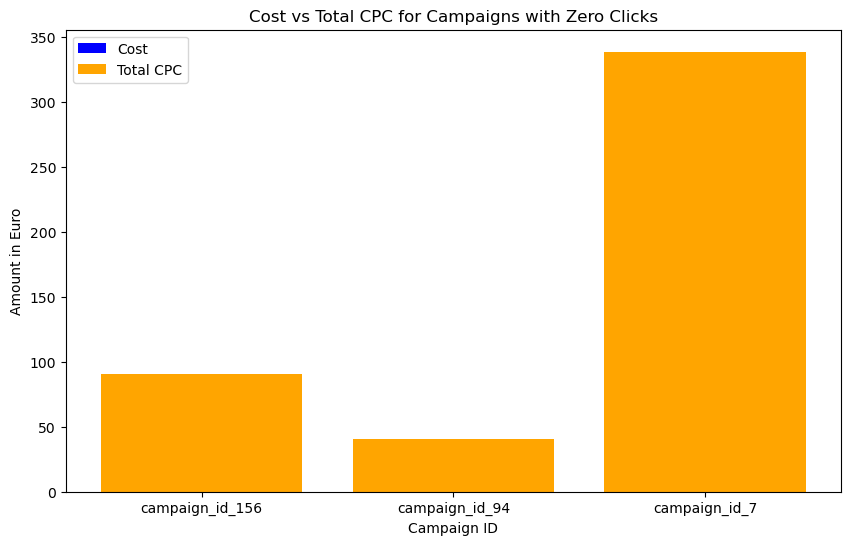

In [180]:
# Group related sessions by campaign_id
campaign_summary = related_sessions.groupby('campaign_id').agg(
    session_count=('session_id', 'count'),
    total_cpc=('cpc', 'sum')
).reset_index()

# Merge with zero_clicks_with_cost to see the cost and session relationship
merged_data = zero_click.merge(campaign_summary, on='campaign_id', how='left')

print(merged_data)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(merged_data['campaign_id'], merged_data['cost'], color='blue', label='Cost')
plt.bar(merged_data['campaign_id'], merged_data['total_cpc'], color='orange', label='Total CPC')
plt.xlabel('Campaign ID')
plt.ylabel('Amount in Euro')
plt.title('Cost vs Total CPC for Campaigns with Zero Clicks')
plt.legend()
plt.show()

This bar plot shows campaign ids with associated cost (from api_adwords_costs) and total cpc (from sessions sources). Of course, for these campaign ids the cost is zero and ironically, the total cpcs are non-zero.